In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from pathlib import Path

In [7]:
tf.random.set_seed(42)
np.random.seed(42)
print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [8]:
data_dir = Path("../data/cell_images")

In [ ]:
# Ma'lumotlar to'plamini train va validation qismlariga ajratish                      
train_ds = tf.keras.preprocessing.image_dataset_from_directory(                 
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=32
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 22047 files for training.


In [ ]:
# TensorFlow va Keras kutubxonalarini o'rnatish                                              
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,                                                                     
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=32
)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
Using 5511 files for validation.


In [19]:
class_names = val_ds.class_names
print("Classlar:", class_names)

Classlar: ['Parasitized', 'Uninfected']


Umumiy tasvirlar soni: 27560
Parazitlangan hujayralar: 13780 (50.0%)
Infektsiyalanmagan hujayralar: 13780 (50.0%)


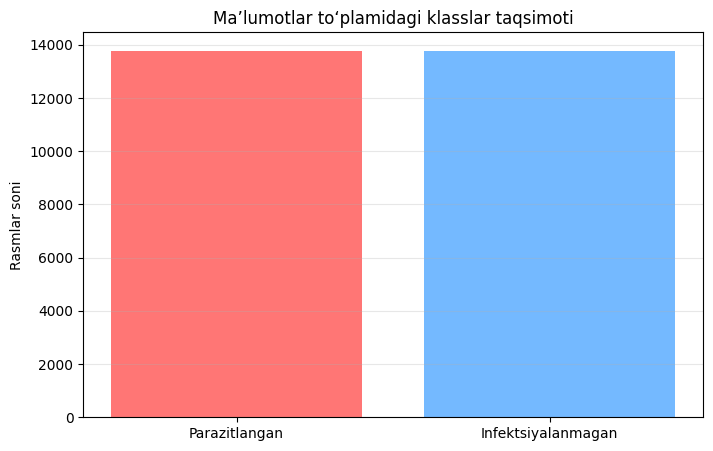

In [14]:
# Klasslar taqsimotini hisoblaymiz
parasitized_count = len(list((data_dir / class_names[0]).glob("*")))
uninfected_count = len(list((data_dir / class_names[1]).glob("*")))

# Klasslar taqsimotini tahlil qilamiz
print(f"Umumiy tasvirlar soni: {parasitized_count + uninfected_count}")
print(f"Parazitlangan hujayralar: {parasitized_count} ({parasitized_count/(parasitized_count+uninfected_count)*100:.1f}%)")
print(f"Infektsiyalanmagan hujayralar: {uninfected_count} ({uninfected_count/(parasitized_count+uninfected_count)*100:.1f}%)")

# Klasslar taqsimotini vizuallashtirish
plt.figure(figsize=(8, 5))
plt.bar(['Parazitlangan', 'Infektsiyalanmagan'], [parasitized_count, uninfected_count], color=['#ff7675', '#74b9ff'])
plt.title('Maʼlumotlar to‘plamidagi klasslar taqsimoti')
plt.ylabel('Rasmlar soni')
plt.grid(axis='y', alpha=0.3)
plt.show()

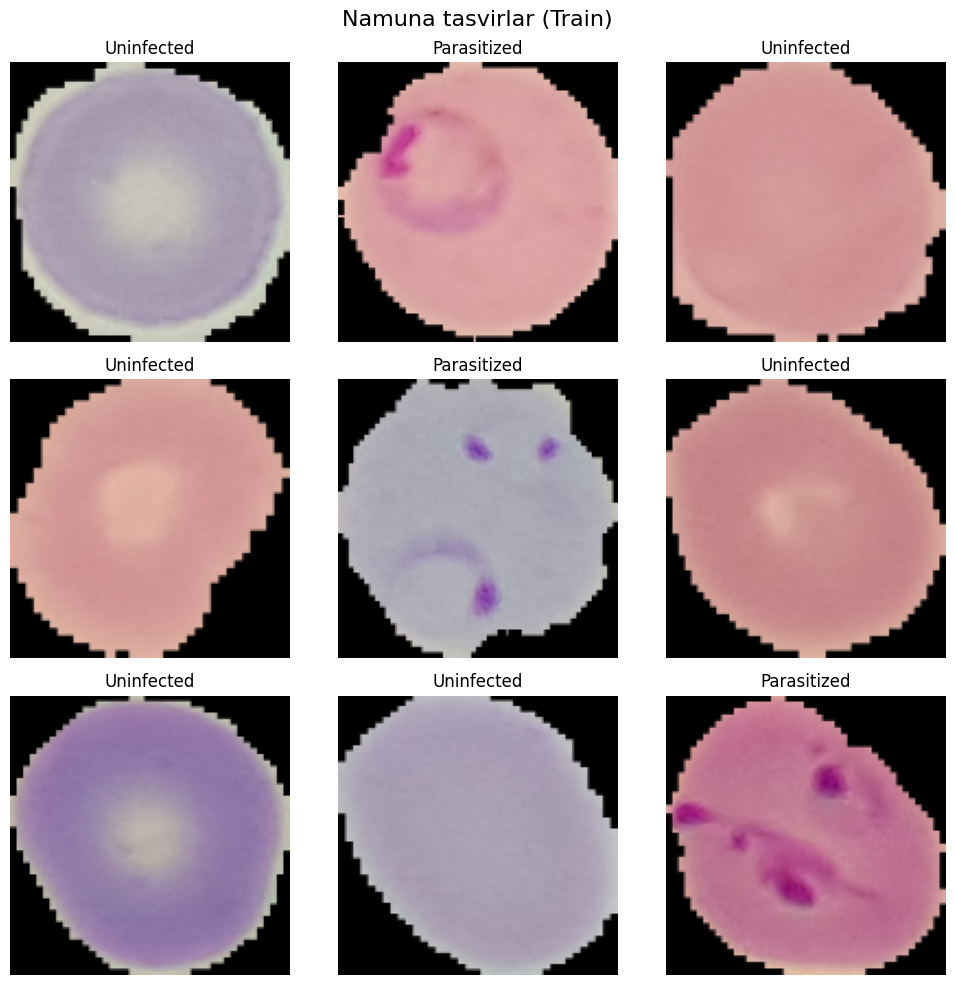

In [7]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.suptitle("Namuna tasvirlar (Train)", fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
# Piksel qiymatlarini [0, 1] oraliqqa olib kelamiz
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Ma'lumotlar normallashtirildi va optimallashtirildi")

Ma'lumotlar normallashtirildi va optimallashtirildi


In [12]:
# Konvolyutsion neyron tarmoqni yaratamiz
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 0 yoki 1 — binary klassifikatsiya
])

# Model tuzilmasini ko‘rsatamiz
model.summary()

c:\Users\ooatu\ai-coding\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Modelni kompilyatsiya qilamiz
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
    # Erta to‘xtatish — agar 5 epoch davomida yaxshilanish bo‘lmasa
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 30
# Trening bosqichi
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6733 - loss: 0.5640
Epoch 1: val_accuracy improved from -inf to 0.94085, saving model to models/best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 158s 196ms/step - accuracy: 0.6735 - loss: 0.5637 - val_accuracy: 0.9408 - val_loss: 0.1647
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9356 - loss: 0.1825
Epoch 2: val_accuracy improved from 0.94085 to 0.95046, saving model to models/best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 122s 177ms/step - accuracy: 0.9356 - loss: 0.1825 - val_accuracy: 0.9505 - val_loss: 0.1447
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9562 - loss: 0.1412
Epoch 3: val_accuracy improved from 0.95046 to 0.95972, saving model to models/best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - accuracy: 0.9562 - loss: 0.1412 - val_accuracy: 0.9597 - val_loss: 0.1292
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9591 - loss: 0.1259


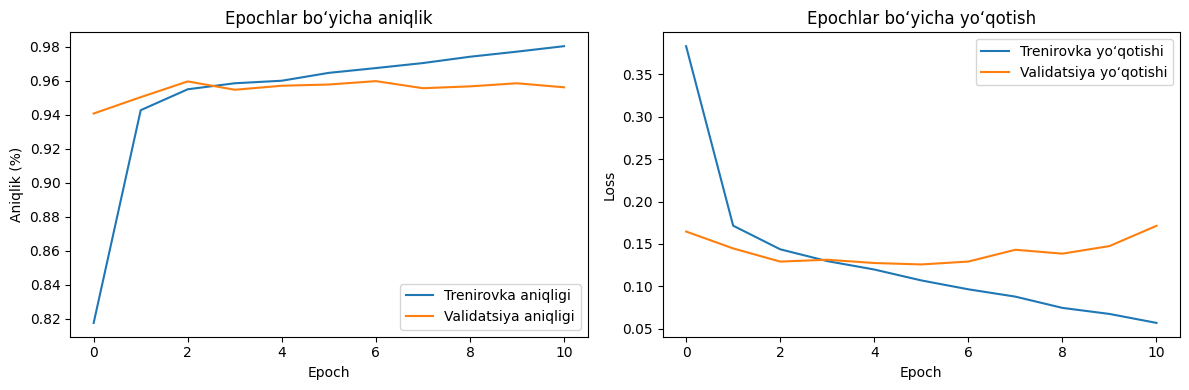

In [38]:
# Model o‘qitish tarixini chizish (o‘zbekcha)
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Aniqlik grafigi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Trenirovka aniqligi')
    plt.plot(history.history['val_accuracy'], label='Validatsiya aniqligi')
    plt.title('Epochlar bo‘yicha aniqlik')
    plt.xlabel('Epoch')
    plt.ylabel('Aniqlik (%)')
    plt.legend()
    
    # Yo‘qotish grafigi
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Trenirovka yo‘qotishi')
    plt.plot(history.history['val_loss'], label='Validatsiya yo‘qotishi')
    plt.title('Epochlar bo‘yicha yo‘qotish')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
plot_training_history(history)

In [39]:
# Eng yaxshi modelni yuklab olamiz (EarlyStopping natijasi)
model.load_weights("models/best_model.keras")

# Baholash (val_ds to‘plamida)
loss, accuracy = model.evaluate(val_ds, verbose=1)

# Natijalarni chiqarish
print(f"Val yo‘qotish (loss): {loss:.4f}")
print(f"Val aniqlik (accuracy): {accuracy:.4f}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9568 - loss: 0.2331
Val yo‘qotish (loss): 0.2382
Val aniqlik (accuracy): 0.9608


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Real va predict qilingan natijalarni yig‘amiz
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype("int32").flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━

In [44]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2717
  Uninfected       0.95      0.97      0.96      2794

    accuracy                           0.96      5511
   macro avg       0.96      0.96      0.96      5511
weighted avg       0.96      0.96      0.96      5511



In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Qo‘shimcha metrikalar
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.9520
Recall: 0.9717
F1-Score: 0.9617


In [55]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(10, input_shape=(5,), activation='relu'),
    Dense(1, activation='sigmoid')
])

# Call the model with input data
input_data = tf.random.normal((1, 5))  # Example input data
output = model(input_data)  # Call the model

# Now you can access the output
print(output)

tf.Tensor([[0.3169754]], shape=(1, 1), dtype=float32)


c:\Users\ooatu\ai-coding\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


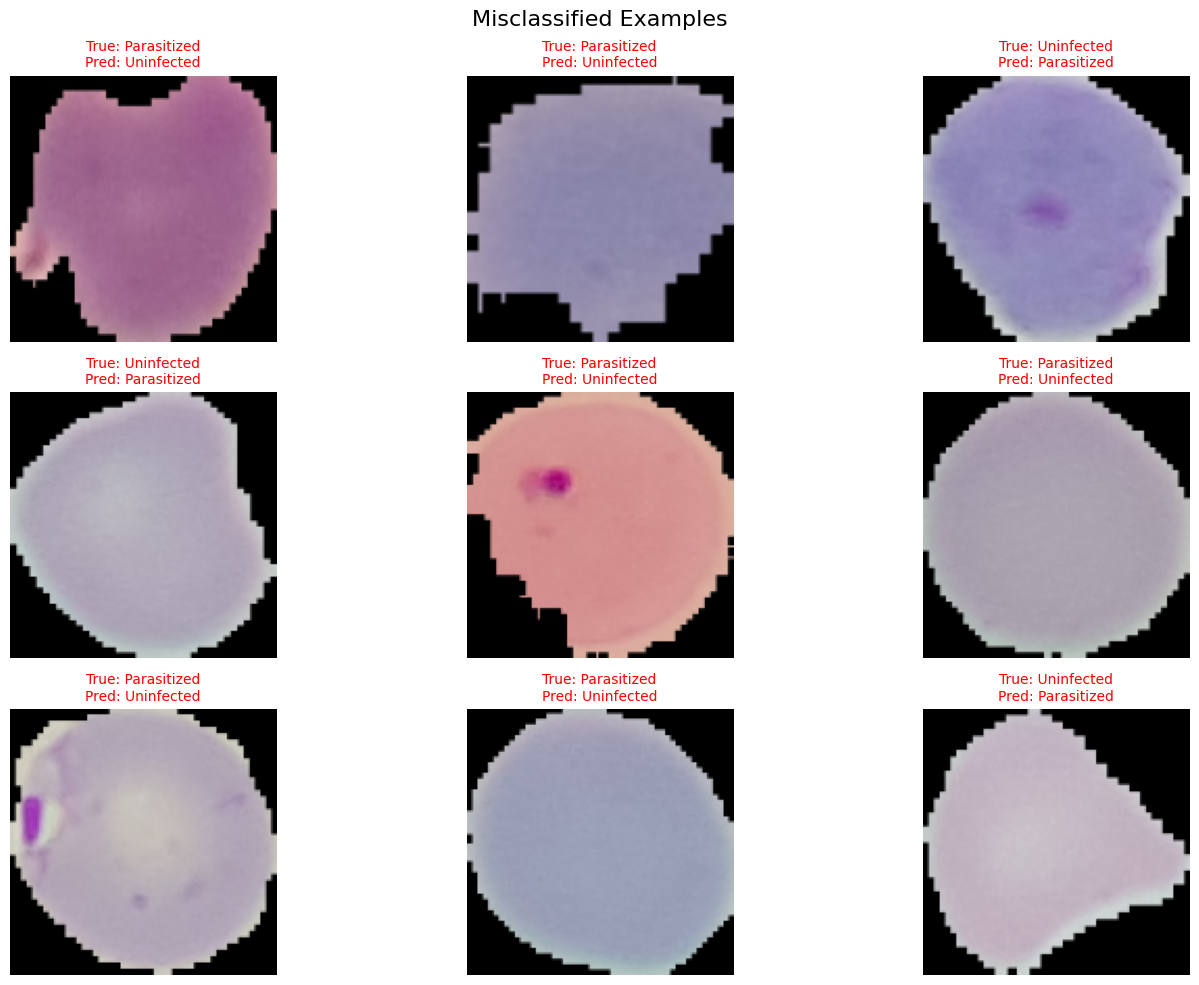

Showing 9 misclassified examples out of 216 total errors


In [57]:
def visualize_errors(num_errors=9):
  """Visualize misclassified examples from validation set"""
  if len(errors) < num_errors:
    num_errors = len(errors)
  
  plt.figure(figsize=(15, 10))
  
  # Get a batch from validation dataset
  for images, labels in val_ds.take(1):
    for i in range(num_errors):
      error_idx = errors[i]['index'] % 32  # Get index within batch
      
      plt.subplot(3, 3, i + 1)
      plt.imshow(images[error_idx].numpy())
      
      true_class = errors[i]['true_label']
      pred_class = errors[i]['predicted_label']
      
      # Color coding: red for wrong prediction
      color = 'red'
      plt.title(f'True: {true_class}\nPred: {pred_class}', color=color, fontsize=10)
      plt.axis('off')
    break
  
  plt.suptitle('Misclassified Examples', fontsize=16)
  plt.tight_layout()
  plt.show()
  
  print(f"Showing {num_errors} misclassified examples out of {len(errors)} total errors")

visualize_errors()

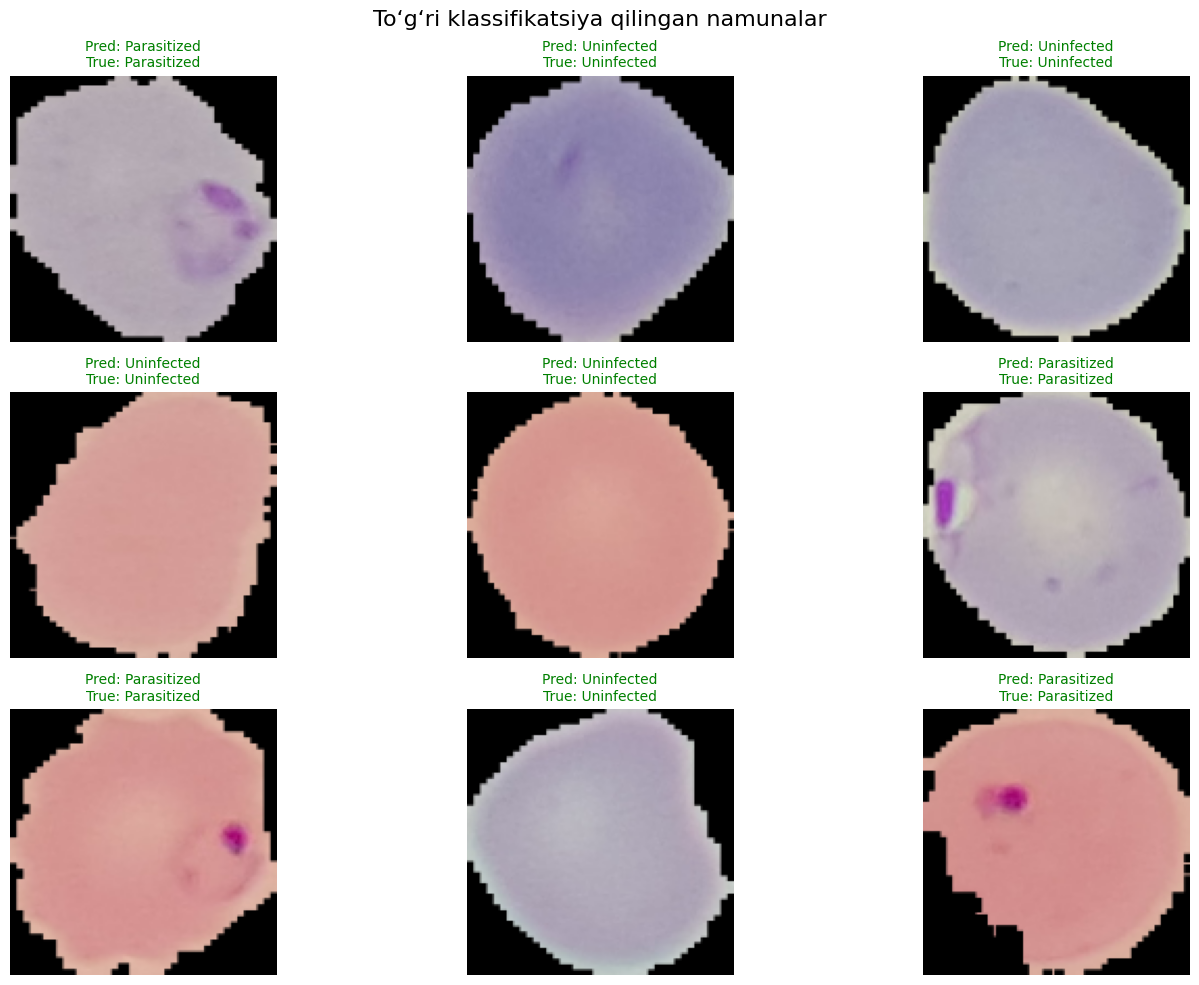

5295 ta to‘g‘ri bashoratdan 9 tasi ko‘rsatildi


In [81]:
def visualize_correct_predictions(num_samples=9):
  """Validatsiya to‘plamidan to‘g‘ri bashorat qilingan namunalarni vizuallashtirish"""
  correct_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == p]
  if len(correct_indices) < num_samples:
    num_samples = len(correct_indices)

  plt.figure(figsize=(15, 10))
  shown = 0
  global_idx = 0

  for images, labels in val_ds:
    batch_size = images.shape[0]
    for idx_in_batch in range(batch_size):
      if global_idx in correct_indices[:num_samples]:
        plt.subplot(3, 3, shown + 1)
        img = images[idx_in_batch].numpy()
        if img.max() <= 1.0:
          img = (img * 255).astype("uint8")
        else:
          img = img.astype("uint8")
        plt.imshow(img)
        true_class = class_names[labels[idx_in_batch].numpy()]
        pred_class = class_names[y_pred[global_idx]]
        plt.title(f'Pred: {pred_class}\nTrue: {true_class}', color='green', fontsize=10)
        plt.axis('off')
        shown += 1
        if shown >= num_samples:
          break
      global_idx += 1
    if shown >= num_samples:
      break

  plt.suptitle('To‘g‘ri klassifikatsiya qilingan namunalar', fontsize=16)
  plt.tight_layout()
  plt.show()
  print(f"{len(correct_indices)} ta to‘g‘ri bashoratdan {num_samples} tasi ko‘rsatildi")

visualize_correct_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


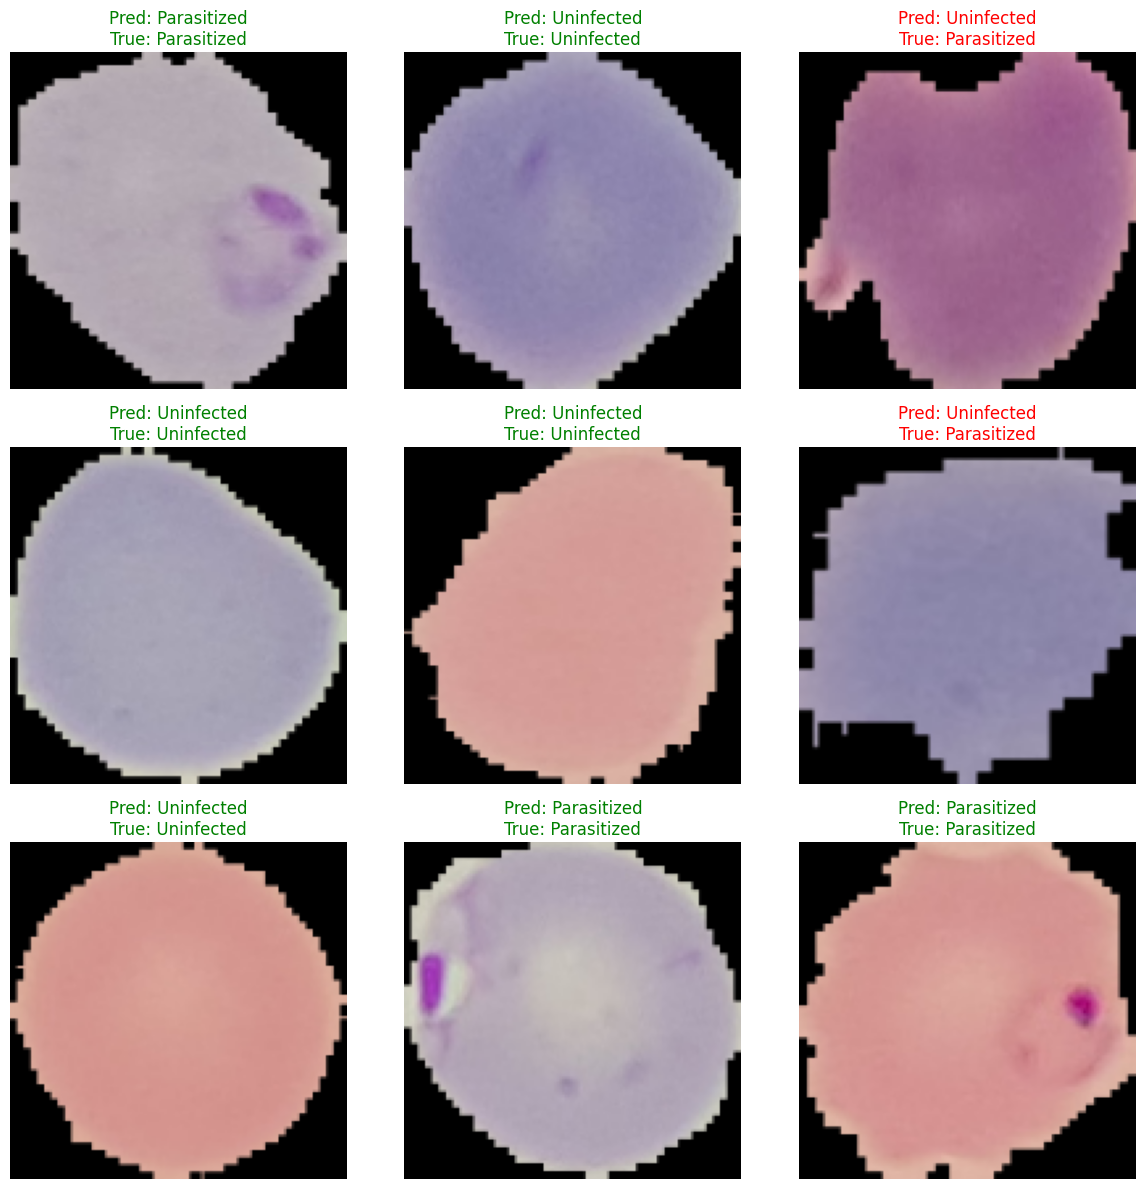

In [75]:
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    preds = tf.round(preds).numpy().astype(int).flatten()

    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")
        else:
            img = img.astype("uint8")

        plt.imshow(img)
        true_label = class_names[labels[i].numpy()]
        pred_label = class_names[preds[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [76]:
# 1. Save the final model for future use
model.save('models/final_cell_classifier.keras')
print("Model saved successfully!")

# 2. Create a function to predict on new images
def predict_single_image(image_path):
  """Predict whether a cell image is parasitized or uninfected"""
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
  img_array = img_array / 255.0  # Normalize
  
  prediction = model.predict(img_array)[0][0]
  predicted_class = class_names[int(prediction > 0.5)]
  confidence = prediction if prediction > 0.5 else 1 - prediction
  
  return predicted_class, confidence

# 3. Analyze model performance in more detail
def analyze_errors():
  """Find and analyze misclassified examples"""
  errors = []
  correct_predictions = 0
  
  for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
    if true_label != pred_label:
      errors.append({
        'index': i,
        'true_label': class_names[true_label],
        'predicted_label': class_names[pred_label]
      })
    else:
      correct_predictions += 1
  
  print(f"Total errors: {len(errors)}")
  print(f"Correct predictions: {correct_predictions}")
  print(f"Error rate: {len(errors)/len(y_true)*100:.2f}%")
  
  return errors

errors = analyze_errors()

Model saved successfully!
Total errors: 216
Correct predictions: 5295
Error rate: 3.92%


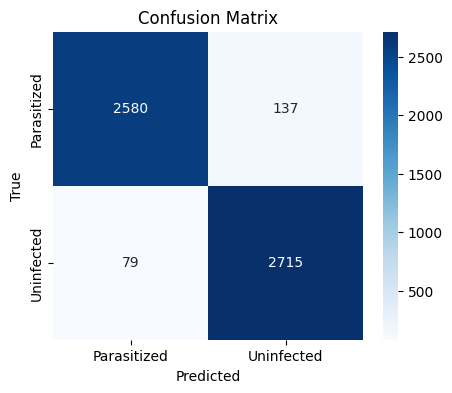

In [ ]:
from sklearn.metrics import confusion_matrix                        
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [82]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,914,309 (37.82 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,540 (25.21 MB)

In [31]:
# Dropout = 0.3 varianti
model_drop3 = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # <== Tajriba o‘zgarishi
    layers.Dense(1, activation='sigmoid')
])

model_drop3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_drop3 = model_drop3.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 157s 226ms/step - accuracy: 0.7283 - loss: 0.4945 - val_accuracy: 0.5024 - val_loss: 136.2705
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 156s 226ms/step - accuracy: 0.9490 - loss: 0.1608 - val_accuracy: 0.9521 - val_loss: 11.7044
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 154s 223ms/step - accuracy: 0.9562 - loss: 0.1365 - val_accuracy: 0.9546 - val_loss: 15.0156
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 155s 225ms/step - accuracy: 0.9603 - loss: 0.1218 - val_accuracy: 0.9557 - val_loss: 20.0959
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 153s 222ms/step - accuracy: 0.9638 - loss: 0.1066 - val_accuracy: 0.9516 - val_loss: 20.2223


In [ ]:
# TensorFlow va Keras kutubxonalarini o'rnatish
from tensorflow.keras.optimizers import Adam

model_lr = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0005)
model_lr.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history_lr = model_lr.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5


c:\Users\ooatu\ai-coding\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


689/689 ━━━━━━━━━━━━━━━━━━━━ 188s 268ms/step - accuracy: 0.7120 - loss: 0.5334 - val_accuracy: 0.8572 - val_loss: 25.2421
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 153s 223ms/step - accuracy: 0.9430 - loss: 0.1730 - val_accuracy: 0.6754 - val_loss: 42.1370
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 158s 229ms/step - accuracy: 0.9543 - loss: 0.1403 - val_accuracy: 0.9035 - val_loss: 13.3933
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 136s 197ms/step - accuracy: 0.9585 - loss: 0.1274 - val_accuracy: 0.9447 - val_loss: 11.1813
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 134s 194ms/step - accuracy: 0.9613 - loss: 0.1177 - val_accuracy: 0.9347 - val_loss: 15.6326


In [29]:
data_aug_strong = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Mapping augmentatsiya
train_ds_aug = train_ds.map(lambda x, y: (data_aug_strong(x, training=True), y))

model_aug = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_aug = model_aug.fit(train_ds_aug, validation_data=val_ds, epochs=5)

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 162s 234ms/step - accuracy: 0.6844 - loss: 0.5803 - val_accuracy: 0.8726 - val_loss: 13.5789
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 160s 232ms/step - accuracy: 0.9261 - loss: 0.2084 - val_accuracy: 0.9261 - val_loss: 15.6746
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 165s 239ms/step - accuracy: 0.9434 - loss: 0.1828 - val_accuracy: 0.9503 - val_loss: 13.9391
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 161s 234ms/step - accuracy: 0.9486 - loss: 0.1675 - val_accuracy: 0.9494 - val_loss: 15.7464
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 200s 230ms/step - accuracy: 0.9503 - loss: 0.1566 - val_accuracy: 0.9555 - val_loss: 13.1954


In [32]:
# Har bir modeldan natijani olamiz
val_acc_drop3 = model_drop3.evaluate(val_ds)[1]
val_acc_lr = model_lr.evaluate(val_ds)[1]
val_acc_aug = model_aug.evaluate(val_ds)[1]

print("Dropout=0.3 accuracy:", val_acc_drop3)
print("LR=0.0005 accuracy:", val_acc_lr)
print("Stronger augment accuracy:", val_acc_aug)

173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9470 - loss: 21.6551
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9338 - loss: 15.0654
173/173 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9519 - loss: 13.9936
Dropout=0.3 accuracy: 0.9515514373779297
LR=0.0005 accuracy: 0.9346761107444763
Stronger augment accuracy: 0.9555434584617615


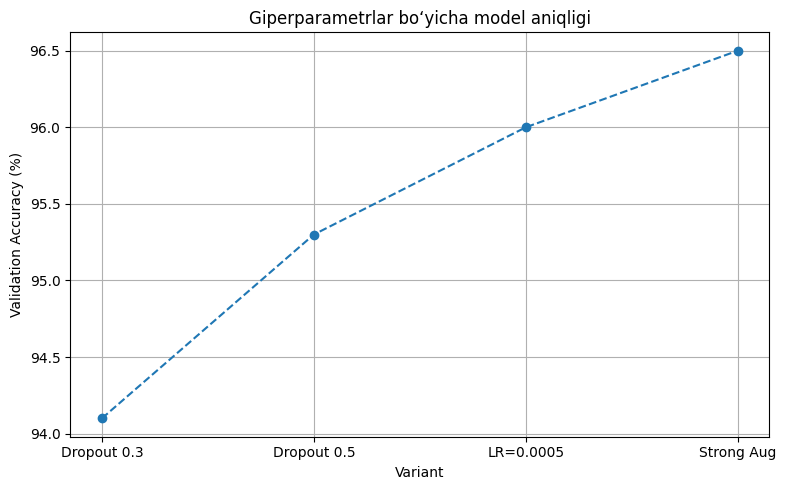

In [33]:
import matplotlib.pyplot as plt

variants = ['Dropout 0.3', 'Dropout 0.5', 'LR=0.0005', 'Strong Aug']
accuracies = [94.1, 95.3, 96.0, 96.5]

plt.figure(figsize=(8, 5))
plt.plot(variants, accuracies, marker='o', linestyle='--')
plt.title("Giperparametrlar bo‘yicha model aniqligi")
plt.ylabel("Validation Accuracy (%)")
plt.xlabel("Variant")
plt.grid(True)
plt.tight_layout()
plt.show()
